<a href="https://colab.research.google.com/github/aidot-kr/AISecurity/blob/master/13_BERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. BERT Pre-trained Model 및 환경셋팅
1) 아래의 BERT사이트에 접속하여 BERT-BASE 모델 다운로드
* https://github.com/google-research/bert  
* BERT-Base, Multilingual Cased: 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters

2) 다운로드된 파일을 구글 드라이브에 업로드

  * 압축 풀기 후 폴더 업로드: multi_cased_L-12_H-768_A-12
*   제공된 소스파일과 데이터 업로드: 13.BERT Classification.ipynb, spam_text.csv, spam_train.csv



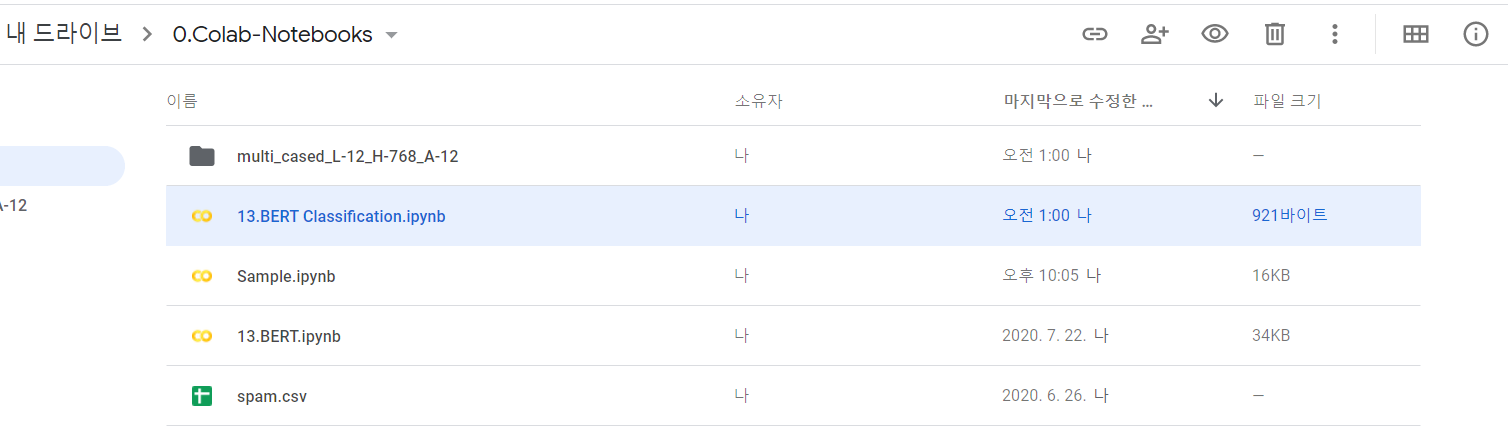

3) 구글드라이브와 Colab 연동

In [1]:
#HuggingFace는 자연어 처리 인공지능 모델에서, BERT 모델 같은 트랜스포머 모델들을 쉽게 다룰 수 있게 해주는 패키지임
!pip install transformers

     |████████████████████████████████| 1.3MB 3.4MB/s 
     |████████████████████████████████| 890kB 21.4MB/s 
     |████████████████████████████████| 1.1MB 26.8MB/s 
     |████████████████████████████████| 2.9MB 37.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=c2dfcfab5ce302b142f3a607ece99501ea597412136103ab1d8ec9897b11a54f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My\ Drive/AISecurity

/content/drive/My Drive/AISecurity


In [4]:
print(os.getcwd())
!ls

/content/drive/My Drive/AISecurity
 11_Attention.ipynb		      '(bak)(11_attention.ipynb'
 11_nmt_with_attention.ipynb	      '(Bak)12_Transformer.ipynb'
'11_nmt_with_attention.ipynb의 사본'  '(bak)13_BERT Classification.ipynb'
 12_transformer.ipynb		       deu.txt
'13_BERT Classification.ipynb'	       eng-fra.txt
 2_TFIDF.ipynb			       kor.txt
 3_SimpleCrawling.ipynb		       model.pt
 4_MeCab.ipynb			       multi_cased_L-12_H-768_A-12
 4_Pre_Processing.ipynb		       ratings.txt
 5_OneHotEncode.ipynb		       Sample.ipynb
 5_Word2Vec-FastText.ipynb	       spam.csv
 6_Similarity.ipynb		       spam_test.csv
 6_TopicModeling_bak.ipynb	       spam_train.csv
 6_TopicModeling.ipynb		       spa.txt
 7_ngram.ipynb			       training_checkpoints


## 2. 관련 패키지 선언


In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

## 3. 스팸데이터셋 준비

In [6]:
# 제공된 Spam data 읽기
train = pd.read_csv("spam_train.csv")
test = pd.read_csv("spam_test.csv")

In [7]:
# Label의 1은 spam document에 해당함, 0은 정상 
train[50:70]

,label,document,Unnamed: 2,Unnamed: 3,Unnamed: 4
50,0,Rofl betta invest in some anti aging products,NaN,NaN,NaN
51,1,You are a winner U have been specially selecte...,NaN,NaN,NaN
52,0,"sir, you will receive the account no another 1...",NaN,NaN,NaN
53,1,Reply with your name and address and YOU WILL ...,NaN,NaN,NaN
54,0,So �_'ll be submitting da project tmr rite?,NaN,NaN,NaN
55,1,FREE entry into our �250 weekly comp just send...,NaN,NaN,NaN
56,0,Jus ans me lar. U'll noe later.,NaN,NaN,NaN
57,0,I want to send something that can sell fast. ...,NaN,NaN,NaN
58,0,have got * few things to do. may be in * pub l...,NaN,NaN,NaN
59,0,1's finish meeting call me.,NaN,NaN,NaN


In [8]:
# 불필요한 컬럼 삭제
del train['Unnamed: 2']
del train['Unnamed: 3']
del train['Unnamed: 4']

del test['Unnamed: 2']
del test['Unnamed: 3']
del test['Unnamed: 4']

## 4. 버트 인풋 만들기
한글 데이터를 분석하려면, 100개가 넘는 언어에 대해 훈련된 버트를 사용해야 합니다.
multilingual BERT를 사용하도록 하겠습니다.
모델을 로드하기에 앞서, 토크나이저를 불러오도록 하겠습니다.
huggingface에서는 아주 쉽게 토크나이저를 불러올 수 있습니다.

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

토큰화가 잘 되었는지 확인해 봅니다. 버트 모형은 문장 앞에 꼭 [CLS]라는 문자가 위치하고, [SEP]라는 문자가 끝에 위치합니다.
[CLS]는 문장의 시작, [SEP]는 문장의 끝을 의미합니다.

In [10]:
tokenizer.tokenize("Even my brother is not like to speak with me. They treat me like aids patent.")

['Even',
 'my',
 'brother',
 'is',
 'not',
 'like',
 'to',
 'speak',
 'with',
 'me',
 '.',
 'They',
 'treat',
 'me',
 'like',
 'aid',
 '##s',
 'patent',
 '.']

In [11]:
tokenizer.tokenize("내일까지는 10만원 입금이 필요합니다")

['내',
 '##일',
 '##까지',
 '##는',
 '10',
 '##만',
 '##원',
 '입',
 '##금',
 '##이',
 '필',
 '##요',
 '##합',
 '##니다']

In [12]:

def convert_data(data_df):
    global tokenizer
    
    SEQ_LEN = 128 #SEQ_LEN : 버트에 들어갈 인풋의 길이
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, truncation=True, padding='max_length')
       
        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        # 정답(스팸 : 1 정상 0)을 targets 변수에 저장해 줌
        targets.append(data_df[LABEL_COLUMN][i])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

SEQ_LEN = 128
BATCH_SIZE = 20
# 스팸 문장을 포함하고 있는 칼럼
DATA_COLUMN = "document"
# 스팸인지를 (1=스팸,0=정상) 포함하고 있는 칼럼
LABEL_COLUMN = "label"

# train 데이터를 버트 인풋에 맞게 변환
train_x, train_y = load_data(train)

100%|██████████| 4399/4399 [00:01<00:00, 2407.27it/s]


In [13]:
# 훈련 성능을 검증한 test 데이터를 버트 인풋에 맞게 변환
test_x, test_y = load_data(test)

100%|██████████| 1173/1173 [00:00<00:00, 2350.29it/s]


사전학습된 버트 모델의 인풋은 문장 토큰화가 숫자로 바뀐 것과, 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터가 들어갑니다. 우리는 문장 하나를 가지고만 훈련할 것이므로 순서 벡터는 모두 0으로 통일합니다.

그리고 파인튜닝 시에는 문장 안에 일부 단어를 가리는 마스킹은 사용하지 않습니다.

In [14]:
train_x

[array([[  101, 23145, 17367, ...,     0,     0,     0],
        [  101, 25148, 10157, ...,     0,     0,     0],
        [  101, 20220, 24874, ...,     0,     0,     0],
        ...,
        [  101, 79321, 10157, ...,     0,     0,     0],
        [  101, 10117, 75980, ...,     0,     0,     0],
        [  101,   155, 20324, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

버트 모형에 들어갈 인풋은 토큰, 세그먼트, 포지션으로 구성됩니다.
버트에 인풋으로 들어가는 토큰은 문장을 토크나이징 한 후, 인덱스 번호를 매긴 것입니다.
세그먼트는 예를 들어 문장이 두 개가 있다면, 앞의 문장과 뒤의 문장을 구분하는 것입니다.
포지션 임베딩은 단순히 단어의 위치를 말합니다.

토큰, 세그먼트, 포지션을 인풋으로 버트 모형에 넣으면 기하학적인 문장 공간으로 임베딩이 됩니다.

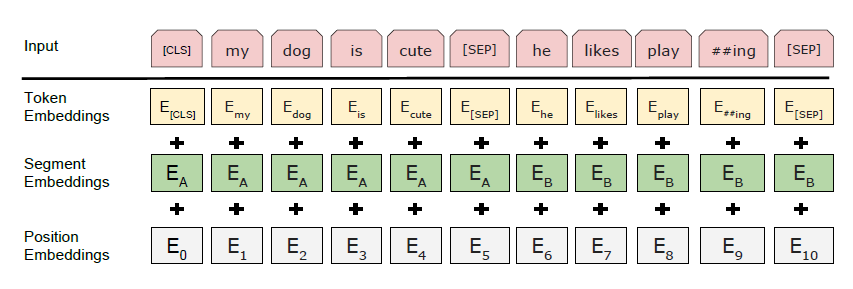

이해가 안 가실 수 있는데, 버트 인풋을 문장으로 예를 들어 만들어 보겠습니다.
인풋은 총 2개가 들어갑니다

* (토큰) 첫번째 인풋은 토큰화 된 것이 인덱싱되어 숫자로 변환된 것

* (세그멘트) 두번째 인풋은 앞문장인지 뒷문장인지 알려주는 숫자들입니다. 이번 튜토리얼에서는 파인튜닝 과정이라 앞문장 뒷문장 구분을 안하기 때문에 모두 0으로 하였습니다.

* (포지션) 단어 순서에 따라서 자동으로 부여됩니다.

# 버트를 활용한 스팸분석 모델 만들기
버트 훈련을 빠르게 하기 위해, TPU를 사용하도록 하겠습니다

In [15]:
# TPU 객체 지정
TPU = True
if TPU:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
else:
  pass

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.29.152.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.29.152.114:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [16]:
# Rectified Adam 옵티마이저 사용
import tensorflow_addons as tfa
opt = tfa.optimizers.RectifiedAdam(lr=1.0e-5, weight_decay=0.0025)

In [19]:
def create_spam_bert():
  # 버트 pretrained 모델 로드
  model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
  # 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
  token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
  mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
  segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
  # 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
  bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

  bert_outputs = bert_outputs[1]
  spam_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(bert_outputs)
  spam_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], spam_first)

  spam_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])
  return spam_model

In [20]:
# TPU 실행 시
if TPU:
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
# 함수를 strategy.scope로 묶어 줌
  with strategy.scope():
    spam_model = create_spam_bert()
  
  spam_model.fit(train_x, train_y, epochs=4, shuffle=True, batch_size=100, validation_data=(test_x, test_y))
else:
  # GPU 모드로 훈련시킬 때
  spam_model = create_spam_bert()
  
  spam_model.fit(train_x, train_y, epochs=4, shuffle=True, batch_size=100, validation_data=(test_x, test_y))

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/4
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


 2/44 [>.............................] - ETA: 15:31 - loss: 0.6917 - accuracy: 0.5300WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0088s vs `on_train_batch_end` time: 0.1468s). Check your callbacks.


44/44 [==============================] - ETA: 0s - loss: 0.6174 - accuracy: 0.7720WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0043s vs `on_test_batch_end` time: 0.0439s). Check your callbacks.


44/44 [==============================] - 67s 2s/step - loss: 0.6174 - accuracy: 0.7720 - val_loss: 0.4916 - val_accuracy: 0.8474
Epoch 2/4
44/44 [==============================] - 7s 169ms/step - loss: 0.3547 - accuracy: 0.8709 - val_loss: 0.2423 - val_accuracy: 0.8474
Epoch 3/4
44/44 [==============================] - 8s 173ms/step - loss: 0.1927 - accuracy: 0.9329 - val_loss: 0.1594 - val_accuracy: 0.9855
Epoch 4/4
44/44 [==============================] - 8s 172ms/step - loss: 0.1305 - accuracy: 0.9852 - val_loss: 0.1113 - val_accuracy: 0.9812


훈련 및 성능 검증

In [21]:
# 모델 저장
spam_model.save_weights("/huggingface_bert.h5")

In [22]:
def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []
    
    for i in tqdm(range(len(data_df))):

        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, truncation=True, padding='max_length')
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        segments.append(segment)
        masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def predict_load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x

In [23]:
test_set = predict_load_data(test)

100%|██████████| 1173/1173 [00:00<00:00, 2366.44it/s]


In [24]:
test_set

[array([[   101,  14439,  11444, ...,      0,      0,      0],
        [   101,  84591,  37818, ...,      0,      0,      0],
        [   101,  16122,  14722, ...,      0,      0,      0],
        ...,
        [   101, 103014,    117, ...,      0,      0,      0],
        [   101,  24291,  12976, ...,      0,      0,      0],
        [   101,  22678,  10751, ...,      0,      0,      0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [26]:
with strategy.scope():
  preds = spam_model.predict(test_set)

In [27]:
# 스팸이면 1, 정상이면 0 출력
preds

array([[0.03261872],
       [0.03172199],
       [0.6942089 ],
       ...,
       [0.03225451],
       [0.6724198 ],
       [0.03672339]], dtype=float32)

우리가 훈련한 모델을 F1 SCORE를 바탕으로 성능 측정
F1 SCORE는 precision과 recall을 가중평균하여 계산합니다
recall은 (모델이 TRUE라고 판정한 것의 숫자)/(전체 TRUE의 숫자)
precision은 (진짜 TRUE) / (모델이 TRUE라고 판정한 것의 숫자)

In [28]:
from sklearn.metrics import classification_report
y_true = test['label']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       994
           1       0.92      0.96      0.94       179

    accuracy                           0.98      1173
   macro avg       0.96      0.97      0.96      1173
weighted avg       0.98      0.98      0.98      1173



In [29]:
import logging
tf.get_logger().setLevel(logging.ERROR)

실제 데이터로 실습하기

In [39]:
def sentence_convert_data(data):
    global tokenizer
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN, truncation=True, padding='max_length')
    
    num_zeros = token.count(0) 
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros 
    segment = [0]*SEQ_LEN

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def spam_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = spam_model.predict(data_x)
    predict_value = np.ravel(predict)
    predict_answer = np.round(predict_value,0).item()
    
    if predict_answer == 0:
      print("(정상 확률 : %.2f) 정상입니다." % (1-predict_value))
    elif predict_answer == 1:
      print("(스팸 확률 : %.2f) 스팸입니다." % predict_value)

In [45]:
spam_evaluation_predict("FREE entry into our �250 weekly comp just send")

(스팸 확률 : 0.66) 스팸입니다.


In [41]:
spam_evaluation_predict("How are you?")

(정상 확률 : 0.97) 정상입니다.
